The SRA libraries where aligned to NCBI RefSeq Flaviviridae sequences (as of April 2020) and nvEVEs previously identified in 10.1186/s13071-021-04828-w

The mapped reads from each SRA library were extracted from BAM files and assembled using SPAdes. The assemblies were pooled into single FASTA file allAssemblies.fasta

The header of each sequence in this file is LibraryID_ContigIDAssigned_by_SPAdes

In [19]:
#generate histogram of assembly lengths
from os import listdir
from os.path import isfile, splitext, join
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from collections import Counter
from os import  listdir
from os.path import  isfile, join, splitext
import hdbscan
from Bio import SeqIO, Seq
import random
wd="/mnt/storage5/anton/Mosquitoes/DENV/InputData/"



Display the distribution of contig lengths. This will be looked at in more detail via violin plots later.

Average contig length: 460 vs trimmed contigs: 321
Median contig length: 200 vs trimmed contigs: 142


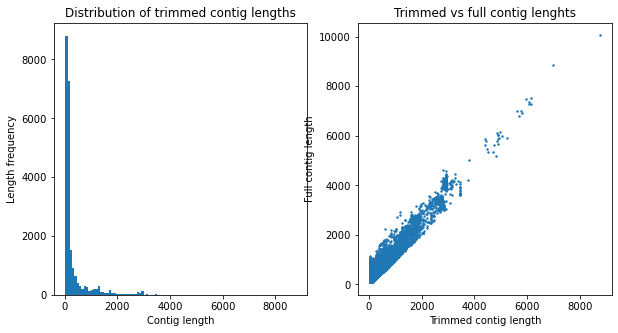

In [2]:
total_contig_lengths={}
total_contig_sequences={}
for contig in SeqIO.parse(wd+"allAssemblies.fasta", "fasta"):
    total_contig_lengths[contig.id]=len(contig.seq)
    total_contig_sequences[contig.id]=str(contig.seq)

trimmed_contig_sequences={}
trimmed_contig_lengths={}
for contig in SeqIO.parse(wd+"allTrimmedExGeneric.fasta", "fasta"):
    trimmed_contig_sequences[contig.id]=str(contig.seq)
    trimmed_contig_lengths[contig.id]=len(contig.seq)

# all_contig_sequences={}
# all_contig_lengths={}
# for contig in SeqIO.parse("/mnt/storage5/anton/Mosquitoes/DENV/DB/allTrimmed.fasta", "fasta"):
#     all_contig_sequences[contig.id]=str(contig.seq)
#     all_contig_lengths[contig.id]=len(contig.seq)


print(f'Average contig length: {int(np.average(list(total_contig_lengths.values())))} vs trimmed contigs: {int(np.average(list(trimmed_contig_lengths.values())))}'  )
print(f'Median contig length: {int(np.median(list(total_contig_lengths.values())))} vs trimmed contigs: {int(np.median(list(trimmed_contig_lengths.values())))}'  )

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].hist(trimmed_contig_lengths.values(), bins=100)
axs[0].set_title("Distribution of trimmed contig lengths")
axs[0].set_xlabel("Contig length")
axs[0].set_ylabel("Length frequency")
temp_keys=list(trimmed_contig_lengths.keys()) #dictionaries are not guaranteed to be iterated in the same order, hence create list of keyes
axs[1].scatter([trimmed_contig_lengths[f] for f in temp_keys],[total_contig_lengths[f] for f in temp_keys], s=2)
axs[1].set_title("Trimmed vs full contig lenghts")
axs[1].set_xlabel("Trimmed contig length")
axs[1].set_ylabel("Full contig length")

plt.show()


Create dictionary mapping geographic regions to SRA library IDs
Also create a legend object for the figures

In [3]:
sampleCountryDic={} #value= Region name is same order as columns in pdvcf dataframe
sampleRegionsDic={} #key=sample, value=region name
with open(wd+"SampleRegions.txt") as file:
    for line in file:
        values=line.strip().split("\t")
        sampleRegionsDic[values[0]]=values[1]
        sampleCountryDic[values[0]]=values[2]

regionColoursDic={}
geographyLegendElements=[]
regionsCmap=plt.cm.get_cmap('tab10', len(set(sampleRegionsDic.values())))
for region in set(sampleRegionsDic.values()):
    regionColoursDic[region]=regionsCmap( len(regionColoursDic) / len( set(sampleRegionsDic.values()) ) )
    geographyLegendElements.append(mpatches.Patch(color=regionColoursDic[region], label=region))

For those libraries that were used in 10.1186/s13071-021-04828-w, load the phylogenetic clades based on mitochondrial Cox1 gene

In [4]:
cox1clades={}  #key=sample ID, value= cox1 gene clade in tree
with open(wd+"Cox1Clades.tsv") as file:
    for line in file:
        values=line.strip().split("\t")
        cox1clades[values[0]]=int(values[1])

In [5]:
#  Load RefSeq virus names. These were used for Bowtie2 mapping and blast search
virusNames={} #key = id, values= description
for record in SeqIO.parse(wd+"RefSeq_ExEVEs.fa", "fasta"):
    virusNames[record.id]=record.description

All mosquito assemblies were blasted against previously identified EVEs (10.1186/s13071-021-04828-w), CFAV (NC_001564.2 based on  10.1016/j.cub.2020.06.057 and 10.1111/mec.15798) and sequences (VIEW) identified in 10.1016/j.cub.2017.09.067
Here, we take all assembled contigs and identify the best matching sequence (either EVE, CFAV or VIEW) for each contig based on BLASTn using ws7

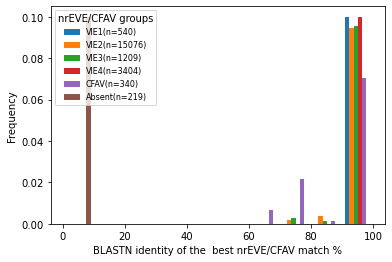

In [6]:
colours=plt.cm.get_cmap('tab10', 6)
eveColours={}
for label in ["VIE1","VIE2","VIE3","VIE4","CFAV","Absent"]:
    eveColours[label]=colours( len(eveColours)/6   )
#eveColours={"VIE1":"red", "VIE2":"blue", "VIE3":"LimeGreen", "VIE4": "BlueViolet", "CFAV": "red","Absent":"green"}
legendElements=[]
for key in eveColours:
    legendElements.append(mpatches.Patch(color=eveColours[key], label=key))

eveAssemblies={} #key=assembly name, value=[VIE#, len, identity]
labels=[]
for file in eveColours.keys():
    fileIdentityValues=[]
    if file=="Absent":
        continue
    with open(wd+"/assembliesVSvie/"+file+".tsv") as blastresults:
        for line in blastresults:
            values=line.strip().split("\t")
            if values[3] not in eveAssemblies:
                eveAssemblies[values[3]]=["Absent",0,0]
            fileIdentityValues.append(float(values[6]))
            if float(values[2])-float(values[1])>=50 and float(values[6])>=eveAssemblies[values[3]][2]:
                eveAssemblies[values[3]]=[file, float(values[2])-float(values[1]),  float(values[6])]
    labels.append(file)

plot_data=[]
label_data=[]
for key in eveColours:
    plot_data.append( [ value[2] for value in eveAssemblies.values() if value[0]==key ] )
    label_data.append( key+"(n="+str(len(plot_data[-1]))+")" )


plt.hist(plot_data, bins=10, density=True, label=label_data)
plt.xlabel("BLASTN identity of the  best nrEVE/CFAV match %")
plt.ylabel("Frequency")
plt.legend(prop={'size': 8}, loc="upper left", title="nrEVE/CFAV groups")
plt.show()
#the clear separation of high and low similarity sequences is clear. This leads to 90% identity as cut-off for particular contig being homologue of EVE or CFAV sequence

All SRA contigs were searched against two collection of sequences: NCBI RefSeq Flaviviridae sequences (as of April 2020) and nvEVEs (listed previously). The results are in 
allAssembliesVsVir.tsv and allAssembliesVsEVE.tsv. 

The SRA contigs from which the generic sequences were trimmed (by removing segments that contain BLASTn ws11 hits against D. rerio reference assembly GCF000002035.6) were searched against each other (i.e. all vs all). The resulting file is allTrimmedBlast.tsv is too big (17Gb) to share. 

For each of these these files two tables are created: 1) sum of lenghts of hits against each subject for viral and EVE hits, length of longest hit for AaegL5 reference hits, 2) lowest e-value against each subject, 3) highest identity level

This doesn't work very well for AaegL5 reference genome because unlike viral genomes and EVEs, in it the highest identity may not be the longest hit.

The results are saved to a file which is too big (18Gb) to upload to github. One of the source files allTrimmedExGenericBlast.tsv is also very large (7Gb), but it can be easily recrated using BLASTn:
    makeblastdb -in allTrimmedExGeneric.fasta -title temp -out tempDB -dbtype nucl  -blastdb_version 4 1>/dev/null
    blastn -query allTrimmedExGeneric.fasta -task 'blastn'  -max_target_seqs 1000000000 -db tempDB -num_threads 8 -evalue 1.0E-5 -word_size 20 -outfmt "6 delim=  qseqid qstart qend sseqid sstart send pident evalue" > allTrimmedExGenericBlast.tsv

In [7]:
import pickle
# data={}
# for file, label in zip(["allAssembliesVsVir.tsv","allAssembliesVsEVE.tsv","allTrimmedExGeneric_vs_AaegL50.tsv","allTrimmedExGenericBlast.tsv"], ["vsVir","vsEVE","vsRef","vsAll"]):
#     print(label)
#     data[label]={}
#     data[label]["rawData"]=pd.read_csv(wd+file, sep="\t", names=["Query","Qstart","Qend","Subject","Start","Send","identity","e-value"],
#         dtype={"Vir": str,"VirStart": int,"VirEnd": int,"Assembly": str,"Astart": int,"Aend": int,"identity": float,"e-value": float})
#     data[label]["rawData"]["HitLength"]=abs(data[label]["rawData"]["Qend"]-data[label]["rawData"]["Qstart"])
#     for pivotLabel, pivotValues, fillvalue in zip(["evaluePivot","identityPivot","hitlengthPivot"],["e-value","identity","HitLength"],[1,0,0]):
#         print(pivotLabel)
#         if pivotValues=="identity": #for identity highest are used.
#             data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.max, fill_value=fillvalue)
#         if pivotValues=="HitLength": #the longest hit is used for matches against reference sequence, but sum is used for virus and EVE hits because viral and EVE genomes used 
#             #are not repetetive unlike mosquito reference
#             if label=="vsRef":
#                 data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.max, fill_value=fillvalue)
#             else:
#                 data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.sum, fill_value=fillvalue)
#         else: #for e-value lowest are used.
#             data[label][pivotLabel]=pd.pivot_table(data[label]["rawData"], index=["Query"], columns=["Subject"], values=[pivotValues], aggfunc=np.min, fill_value=fillvalue)
#         data[label][pivotLabel].columns=[f[1] for f in data[label][pivotLabel].columns]

# # This orients the matrix in the same way as the rest: Contigs X Subject (EVE)
# for key in ["evaluePivot","identityPivot","hitlengthPivot"]:
#     data["vsEVE"][key]=np.transpose(data["vsEVE"][key])

# # The BLASTn search against virus and EVEs was done using full (i.e. untrimmed and including generic sequences) contigs
# # This leads to differences in contigs in ["vsVir","vsEVE","vsRef"] and ["vsAll"]
# # The generic contigs need to be removed from these former three dataframes
# for label in ["vsVir","vsEVE","vsRef"]:
#     for pivotLabel in ["evaluePivot","identityPivot","hitlengthPivot"]:
#         data[label][pivotLabel] = data[label][pivotLabel].loc[ np.intersect1d( data["vsAll"][pivotLabel].index, data[label][pivotLabel].index)  ]


# with open(wd+"allBlastResultsExGeneric.pkl", 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


#### This file is 18Gb, so can't be put on Github
with open(wd+"allBlastResultsExGeneric.pkl", 'rb') as handle: #the assembly contigs are only parts that have match against either EVEs or viruses and excluding matches against D. rerio
    data = pickle.load(handle)


For each contig, identify the best EVE and virus match. Also check if sequences has hits against the AaegL5 reference assembly. 

Create a data frame where each assembled contig will have it's best matching EVE, viral and AaegL5 

In [9]:
columnToEveGroup={"Absent":"Absent"}
for index in data["vsEVE"]["evaluePivot"].columns:
        if index.find("AE")>-1:
                columnToEveGroup[index]="VIE"+index.split(".")[1]
        elif index=="NC_001564.2":
                columnToEveGroup[index]="CFAV"
        elif index=="NC_035108.1:461326757-461327206":
                columnToEveGroup[index]="VIE2"

column_names=["id","evalue","length","identity"]
best_matches=pd.DataFrame(index=data["vsAll"]["evaluePivot"].index, columns=[
                "EVE_id","EVE_evalue","EVE_length","EVE_identity",
                "vir_id","vir_evalue","vir_length","vir_identity",
                "mosquito_id","mosquito_evalue","mosquito_length","mosquito_identity"]  )
for postfix, default_value in zip(column_names,["Absent",1,0,0]):
        for prefix in ["EVE","vir","mosquito"]:
                best_matches[prefix+"_"+postfix]=default_value

for label, prefix in zip(["vsVir","vsEVE","vsRef"],["vir","EVE","mosquito"]):
        column_names_to_use=[prefix+"_"+f for f in column_names]
        for contig_id in data[label]["evaluePivot"].index: 
                bestHits=data[label]["evaluePivot"].columns[data[label]["evaluePivot"].loc[contig_id]==data[label]["evaluePivot"].loc[contig_id].min()]
                if len(bestHits)>1:
                        among_the_longest = data[label]["hitlengthPivot"].loc[contig_id] > data[label]["hitlengthPivot"].loc[contig_id][list(bestHits)].max()*0.9
                        sufficiently_long = data[label]["hitlengthPivot"].loc[contig_id] > 100
                        longest=data[label]["hitlengthPivot"].columns[  (among_the_longest) |  (sufficiently_long) ]
                        if len(longest)>1:
                                mostIdentical=data[label]["identityPivot"].columns[data[label]["identityPivot"].loc[contig_id]==data[label]["identityPivot"].loc[contig_id][list(longest)].max()]
                                randomColumn=random.sample(list(mostIdentical), k=1)[0] #this is nececssary to randomise hits when two EVE a excellent mathces
                                best_matches.loc[contig_id, column_names_to_use]=[randomColumn,data[label]["evaluePivot"].at[contig_id,randomColumn], data[label]["hitlengthPivot"].at[contig_id,randomColumn],data[label]["identityPivot"].at[contig_id,randomColumn]]
                        else:
                                best_matches.loc[contig_id, column_names_to_use]=[longest[0],data[label]["evaluePivot"].at[contig_id,longest[0]], data[label]["hitlengthPivot"].at[contig_id,longest[0]],data[label]["identityPivot"].at[contig_id,longest[0]]]
                else:
                        best_matches.loc[contig_id, column_names_to_use]=[bestHits[0],data[label]["evaluePivot"].at[contig_id,bestHits[0]], data[label]["hitlengthPivot"].at[contig_id,bestHits[0]],data[label]["identityPivot"].at[contig_id,bestHits[0]]]

#relabel the individual EVE elements VIE groups
best_matches["EVE_id"]=[columnToEveGroup[f] for f in  best_matches["EVE_id"]]
best_matches["full_contig_length"]=[total_contig_lengths[f] for f in best_matches.index]
best_matches["trimmed_contig_length"]=[trimmed_contig_lengths[f] for f in best_matches.index]



Create embedding of the all vs all BLASTn search into 2D to understand the results structure. The random_state allow replication of the UMAP runs. 

The distance measure is the e-value from BLASTn results. For the results without a match, e-value is set to 1.

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
No handles with labels found to put in legend.


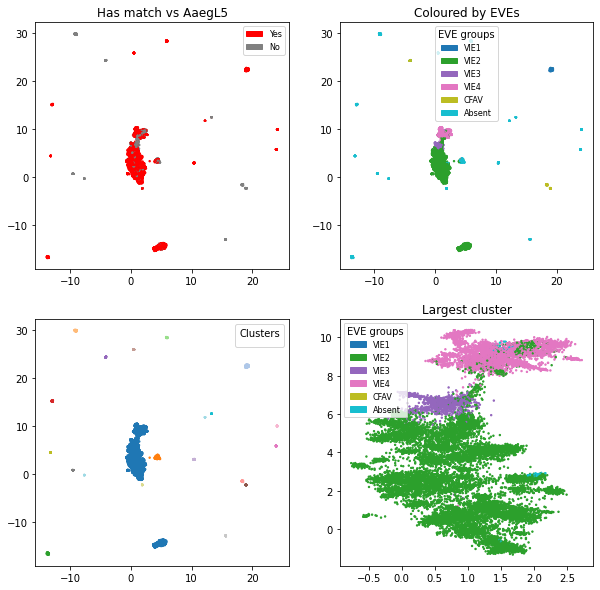

In [11]:
embedding_data=data["vsAll"]["evaluePivot"]
embeddedVCF=umap.UMAP(n_neighbors=50, min_dist=0.1, metric="precomputed", random_state=42).fit_transform(embedding_data)

#To make the labelling of clusters more rational, label them from 1 to N with 1 being the largest cluster and N the smallest
clusters = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.5).fit(embeddedVCF).labels_
labels_sorted_by_size=sorted(Counter(clusters), key=Counter(clusters).get, reverse=True)
clusters=np.asarray([labels_sorted_by_size.index(f)+1  for f in clusters])


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10,10)

axs[0,0].set_title("Has match vs AaegL5")
axs[0,0].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ "red" if best_matches.loc[f,"mosquito_identity"]>90 else "grey" for f in  embedding_data.index ])
axs[0,0].legend(handles=[mpatches.Patch(color="red", label="Yes"),mpatches.Patch(color="grey", label="No")],prop={'size': 8}, loc="best")
axs[0,1].set_title("Coloured by EVEs")
axs[0,1].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[ eveColours[best_matches.loc[f,"EVE_id"]]  for f in  embedding_data.index ])
axs[0,1].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
axs[1,0].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=clusters, cmap="tab20")
axs[1,0].legend(loc="best", title="Clusters")


counter=0
for key in sorted(Counter(clusters), key=Counter(clusters).get, reverse=True):
    if counter>0:
        break
    #create subplot for the largest cluster 
    largestClusterMask=np.where(clusters==key)[0]
    axs[1,counter+1].scatter(embeddedVCF[largestClusterMask,0],embeddedVCF[largestClusterMask,1], s=2, 
        c=[ eveColours[best_matches.loc[f,"EVE_id"]]  for f in  embedding_data.index[largestClusterMask] ])
    axs[1,counter+1].legend(handles=legendElements,prop={'size': 8}, loc="best", title="EVE groups")
    if counter==0:
        axs[1,counter+1].set_title("Largest cluster")
    counter+=1
plt.show()



Save Figure 1

In [ ]:
plt.figure(figsize=(8, 6), dpi=600)
plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=1, c=[ eveColours[best_matches.loc[f,"EVE_id"]]  for f in  embedding_data.index ])
plt.legend(handles=legendElements,prop={'size': 8}, loc="lower right", title="EVE groups")
plt.xlabel("Embedding 1",  fontsize=11)
plt.ylabel("Embedding 2", fontsize=11)
plt.show()


Display location of key clusters

In [ ]:
for cluster in [1,4,2,3]:
    plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=1, c=[ "red" if f==cluster else "grey" for f in  clusters ])
    plt.title(str(cluster))
    plt.show()
plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=1, c=[ "red" if f==9 or f==12  else "grey" for f in  clusters ])
plt.title("12 and 9")
plt.show()

Create projection of the points belonging to the largest cluster to see the if this will produce structure of that cluster different from the one given by embedding of all the data. The actual result is very similar.

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


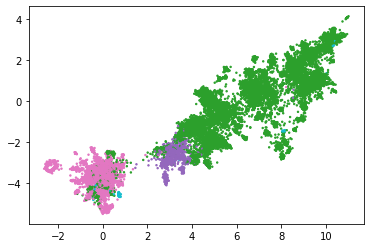

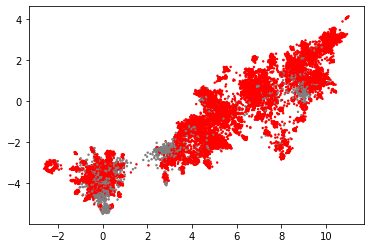

In [12]:
embeddedVCF_subset=umap.UMAP(n_neighbors=20, min_dist=0.1, metric="precomputed", random_state=42).fit_transform(embedding_data.loc[embedding_data.index[clusters==1]][embedding_data.columns[clusters==1]])
plt.scatter(embeddedVCF_subset[:,0],embeddedVCF_subset[:,1], s=2, 
        c=[  eveColours[best_matches.loc[f,"EVE_id"]]  for f in  embedding_data.index[clusters==1]  ])
plt.show()
plt.scatter(embeddedVCF_subset[:,0],embeddedVCF_subset[:,1], s=2, 
        c=[ "red" if best_matches.loc[f,"mosquito_identity"]>90 else "grey"  for f in  embedding_data.index[clusters==1] ])
plt.show()


Save projection results into a file 

In [15]:
best_matches["Dim1"]=embeddedVCF[:,0]
best_matches["Dim2"]=embeddedVCF[:,1]
best_matches["Cluster"]=clusters
best_matches["trimmed_contig_sequence"]=[trimmed_contig_sequences[f] for f in best_matches.index]
best_matches.to_csv(f'{wd}/SequenceData.tsv',sep="\t")


Show distribution of lenghts of contig lenghts in each embedded cluster.

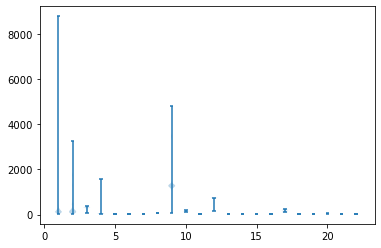

In [136]:
violinData=[]
violinPositions=[]
for key in Counter(clusters):
    violinData.append( [trimmed_contig_lengths[f] for f in best_matches.index[clusters==key] ]   )
    violinPositions.append(key)
plt.violinplot(violinData, violinPositions ,points=100, bw_method=0.1 )
plt.ylim( (0, 1000) )
plt.show()

Generate Table 1

In [25]:
#Count how many samples per country belong to a cluster
allSamples=np.unique([f.split("_")[0] for f in embedding_data.index])
countryCounts=Counter([ sampleCountryDic[f] for f in allSamples    ])
clusterCounts={}
for i in range(0,len(embedding_data.index)):
    if clusters[i] not in clusterCounts:
        clusterCounts[ clusters[i] ]=set()
    clusterCounts[ clusters[i] ].add(embedding_data.index[i].split("_")[0])
samplesPerCluster=pd.DataFrame(0.0,index=clusterCounts.keys(), columns=countryCounts.keys(), )
samplesPerCluster.index.name="Cluster"
for cluster in clusterCounts:
    countriesInCluster=Counter([sampleCountryDic[f] for f in  clusterCounts[cluster] ])
    for country in countriesInCluster:
        samplesPerCluster.at[cluster,country] = countriesInCluster[country]/countryCounts[country]
samplesPerCluster["Total Isolates"]=[len(clusterCounts[f]) for f in samplesPerCluster.index ]
samplesPerCluster["Contigs in cluster"]=[ Counter(clusters)[f] for f in samplesPerCluster.index ]
samplesPerCluster["Contigs in cluster"]=[ Counter(clusters)[f] for f in samplesPerCluster.index ]
samplesPerCluster["Median trimmed contig length"]=[ np.median(best_matches.loc[clusters==f]["trimmed_contig_length"]) for f in samplesPerCluster.index ]
samplesPerCluster["Contigs with BLASTn hits to Ae. aegypti reference"]=[ np.count_nonzero((best_matches["Cluster"]==f) & (best_matches["mosquito_id"]!="Absent")) for f in samplesPerCluster.index ]
samplesPerCluster["Contigs most similar to EVEs"]=[ np.count_nonzero((best_matches["Cluster"]==f) & (best_matches["EVE_id"]!="Absent") & (best_matches["EVE_id"]!="CFAV")) for f in samplesPerCluster.index ]
samplesPerCluster["Contigs most similar to CFAV"]=[ np.count_nonzero((best_matches["Cluster"]==f) & (best_matches["EVE_id"]=="CFAV")) for f in samplesPerCluster.index ]

#determine the number of unique nucleotide sequences in each cluster
samplesPerCluster["Unique trimmed sequences"]=0
for cluster in samplesPerCluster.index:
    unique_cluster_sequences=set()
    for sequence in best_matches.loc[best_matches["Cluster"]==cluster]["trimmed_contig_sequence"]:
        sequence = Seq.Seq(sequence)
        if str(sequence) not in unique_cluster_sequences and str(sequence.reverse_complement()) not in unique_cluster_sequences:
            unique_cluster_sequences.add(str(sequence))
    samplesPerCluster.loc[cluster,"Unique trimmed sequences"]=len(unique_cluster_sequences)

samplesPerCluster.sort_values(by=['Cluster'], inplace=True)
samplesPerCluster.to_csv(f'{wd}/Table1.tsv',sep="\t")

Show the location of the clusters 9, 10 and 12 on the CFAV genome

Cluster 9
Cluster 10
Cluster 12
Cluster 9
Cluster 10
Cluster 12
Cluster 9
Cluster 10
Cluster 12


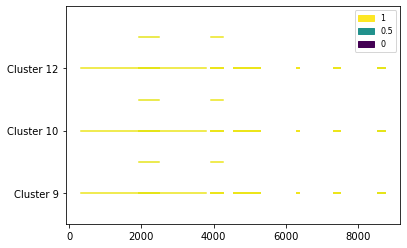

In [72]:
cluster_to_chart=[9, 10, 12]
for cluster_counter, cluster in enumerate(cluster_to_chart):
    cluster_contigs=set(best_matches.index[best_matches["Cluster"]==cluster])
    cluster_hits[cluster]=data["vsVir"]["rawData"].loc[ (data["vsVir"]["rawData"]["Subject"]=="NC_001564.2") & (data["vsVir"]["rawData"]["Query"].isin(cluster_contigs))]

    print(label)
    hitCounter=0
    for index in cluster_hits[].index:
        hit=cluster_hits.loc[index]
        yOffset=int(cluster_counter+1/min(len(cluster_hits),20)*hitCounter)
        plt.plot( [hit["Start"],hit["Send"]], [yOffset,yOffset], c=plt.cm.viridis(int(hit["identity"])/100))
        hitCounter+=1
        if hitCounter>20:
            break
    ylabelLocations.append(cluster_counter)
    cluster_counter+=2


legendElements=[]
legendElements.append(mpatches.Patch(color=plt.cm.viridis(1.0), label="1"))  
legendElements.append(mpatches.Patch(color=plt.cm.viridis(0.85), label="0.85"))
legendElements.append(mpatches.Patch(color=plt.cm.viridis(0.7), label="0.7"))    
plt.legend(handles=legendElements,prop={'size': 8}, loc="best")
plt.ylim( (0,cluster_counter ) )
plt.yticks(ticks=ylabelLocations, labels=[f'Cluster {f}' for f in cluster_to_chart])
plt.show()